In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
import PIVutils
import PODutils
from scipy import interpolate

from sklearn.manifold import LocallyLinearEmbedding
from time import time
#from scipy import interpolate.interp2d

saveFolder = '/Users/Owen/Dropbox/Python Codes/ASIIT/Data/'
saveFile = 'RNV45-thumbs.hdf5'
imgFolder = saveFolder[:-5] + 'RNV45-LLEthumbs'

OriginalDataset = '/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat'

import os
if not os.path.exists(saveFolder):
    os.makedirs(saveFolder)

In [33]:
ThumbParams = PIVutils.loadDataset(saveFolder + saveFile, [],['ThumbParams'])
ThumbParams = ThumbParams[0]

['Cond', 'Prof', 'S', 'Sr', 'ThumbParams', 'U', 'Ur', 'V', 'Vr', 'X', 'Y', 'Yind_Pro', 'Yind_Ret', 'Ypos_Pro', 'Ypos_Ret', 'Yvec', 'missVecs', 'missVecs_Ret', 'x', 'y']


In [34]:
num_features_Pro = ThumbParams["num_features_Pro"]
BoxSize = ThumbParams['BoxSize']

# Test the result on a randomized sample of the data

In [35]:
X, Y, U, V, Swirl, Cond, Prof = PIVutils.loadDataset(OriginalDataset,\
                                                     ['X','Y','U','V','Swirl'],['Cond','Prof'],matlabData = True)

['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


In [36]:
X = X/Cond["delta"]
Y = Y/Cond["delta"]
uSize = U.shape

In [37]:
#Interpolate missing vectors
for i in range(uSize[2]):
    #print(i)
    f = interpolate.interp2d(X[0,:], Y[:,0], U[:,:,i], kind='linear')
    U[:,:,i] = f(X[0,:],Y[:,0])
    f = interpolate.interp2d(X[0,:], Y[:,0], V[:,:,i], kind='linear')
    V[:,:,i] = f(X[0,:],Y[:,0])   
    f = interpolate.interp2d(X[0,:], Y[:,0], Swirl[:,:,i], kind='linear')
    Swirl[:,:,i] = f(X[0,:],Y[:,0]) 

In [47]:
reload(PIVutils)

Ut, Vt, St, Yind = PIVutils.getRandomThumbnails2D(U,V,Swirl,num_features_Pro,BoxSize)

/Users/Owen/Dropbox/Python Codes/ASIIT/PIVutils.py:350: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  Pos = np.random.rand(3,numSamp)
/Users/Owen/Dropbox/Python Codes/ASIIT/PIVutils.py:366: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  Ut = np.zeros([2*BoxSize+1,2*BoxSize+1,numSamp])
/Users/Owen/Dropbox/Python Codes/ASIIT/PIVutils.py:373: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  Uf2 = np.zeros([uSize[0]+2*BoxSize,uSize[1]+2*BoxSize,uSize[2]])
/Users/Owen/Dropbox/Python Codes/ASIIT/PIVutils.py:378: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  Uf2[BoxSize:-1*BoxSize,BoxSize:-1*BoxSize,:] = Uf.copy()
/Users/Owen/Dropbox/Python Codes/ASIIT/PIVutils.py:379: VisibleDeprecationWarning: converting an array with ndim > 0 to a

### Now do a range of different manifold learning on the resulting thumbnails

In [48]:
#Set all NaNs to zero
Ut[np.isnan(Ut)] = 0
Vt[np.isnan(Vt)] = 0

uSize = Ut.shape

In [49]:
ncomp = 4
nneigh = 50

In [50]:
uAll = np.concatenate((Ut.reshape(uSize[0]*uSize[1],uSize[2]), Vt.reshape(uSize[0]*uSize[1],uSize[2])), axis = 0).T
#uAll.shape      

#### Do modified LLE

In [51]:
t0 = time()
model = LocallyLinearEmbedding(n_neighbors=nneigh, n_components=ncomp, method='modified', eigen_solver='dense')
#outLLEmod = model.fit_transform(Ut.reshape(uSize[0]*uSize[1],uSize[2]).T)
outLLEmod = model.fit_transform(uAll)
print((time() - t0)/60, " mins")

2.862470297018687  mins


In [95]:
ypos = np.zeros(Ut.shape[2])

thumb=0
for i in range(Yind[0].shape[0]):
    ypos[thumb] = Y[Yind[0,i],0]
    thumb+=1

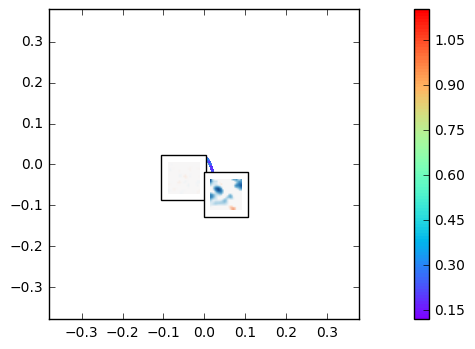

In [96]:
from matplotlib import offsetbox,colors

colorize = dict(c=ypos, cmap=plt.cm.get_cmap('rainbow', 100))
fig, ax = plt.subplots()
h = ax.scatter(outLLEmod[:, 0], outLLEmod[:, 1],s=2, facecolor='0.5', lw = 0, **colorize)
fig.colorbar(h, ax=ax)
plt.axis('scaled')
bound = np.max(np.absolute(outLLEmod))
ax.set_xlim(-1*bound,bound)
ax.set_ylim(-1*bound,bound)

thumb_frac=0.4
cmap='RdBu_r'

min_dist_2 = (thumb_frac * max(outLLEmod.max(0) - outLLEmod.min(0))) ** 2
shown_images = np.array([2 * outLLEmod.max(0)])
for i in range(outLLEmod.shape[0]):
    dist = np.sum((outLLEmod[i] - shown_images) ** 2, 1)
    if np.min(dist) < min_dist_2:
        # don't show points that are too close
        continue
    shown_images = np.vstack([shown_images, outLLEmod[i]])
    
    vecNorm = (outLLEmod[i,0]**2 + outLLEmod[i,1]**2)**0.5
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(St[:,:,i], cmap=cmap, norm=colors.Normalize(-50,50),zoom=1.5),
                              xybox=0.05*outLLEmod[i,0:2]/vecNorm+outLLEmod[i,0:2],xy=outLLEmod[i,0:2], arrowprops=dict(arrowstyle="->"))
    ax.add_artist(imagebox)
    #imagebox.set_clim([-1*10, 10])

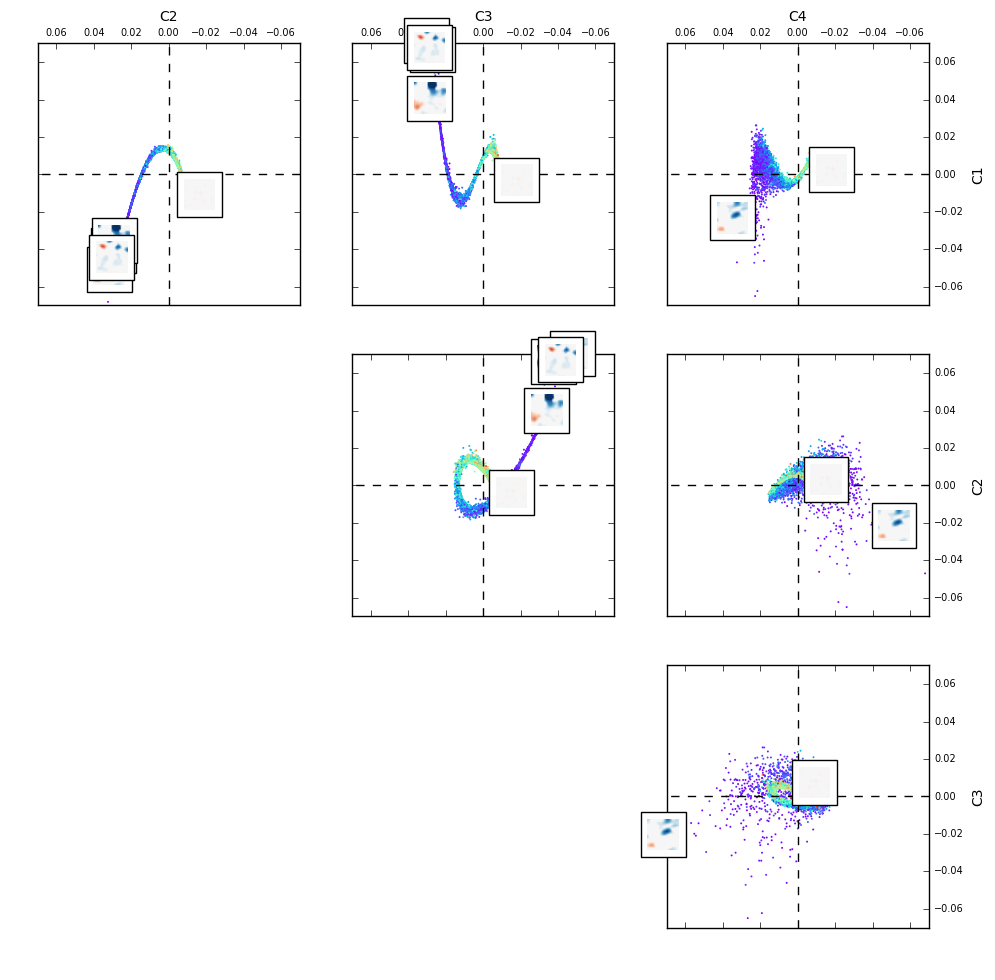

In [103]:
reload(PODutils)
PODutils.plotLLEscatter(outLLEmod.T,ypos,St,list(range(ncomp)),bound=0.07,thumb_frac=0.2,VecDist=0.01,saveFolder=(saveFolder + '/Rand_LLEscatter_mod.tif'))

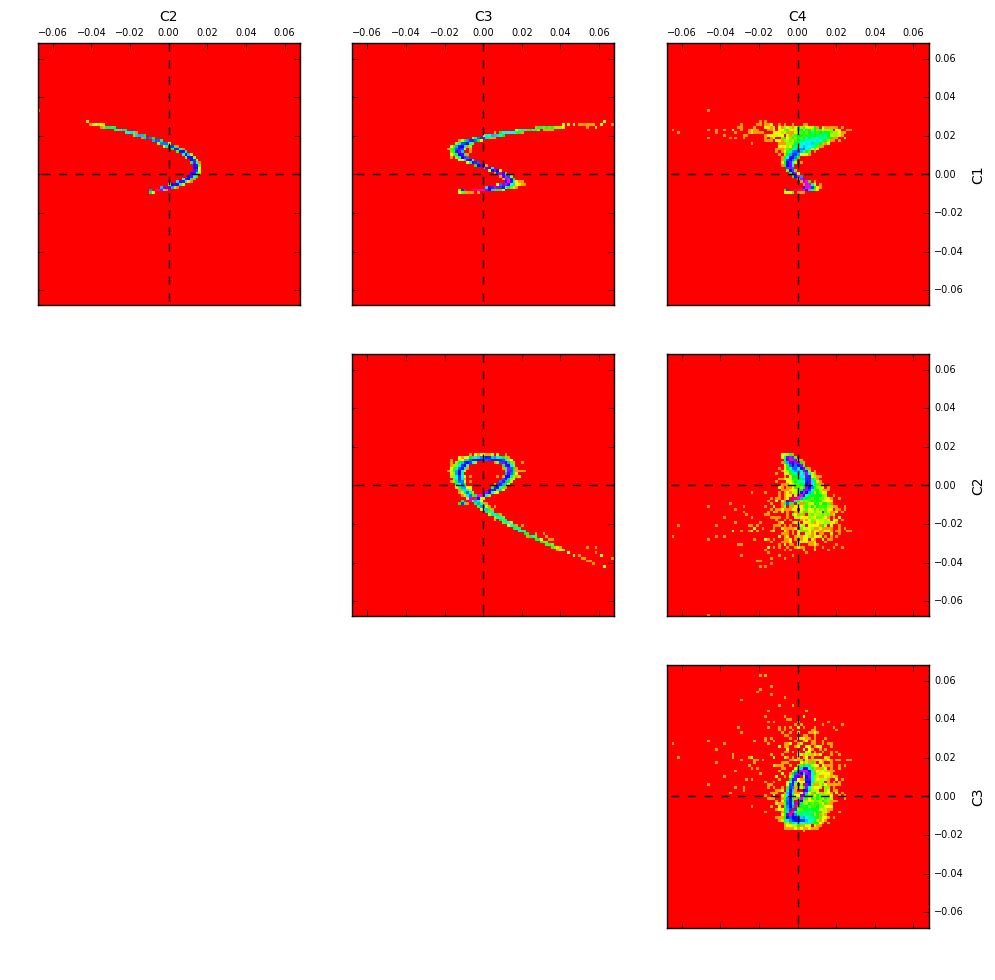

In [104]:
reload(PODutils)
PODutils.plotPODcoeff(outLLEmod.T,list(range(ncomp)),100,0.07,1,saveFolder=(saveFolder + '/Rand_Coeff_mod.tif'))

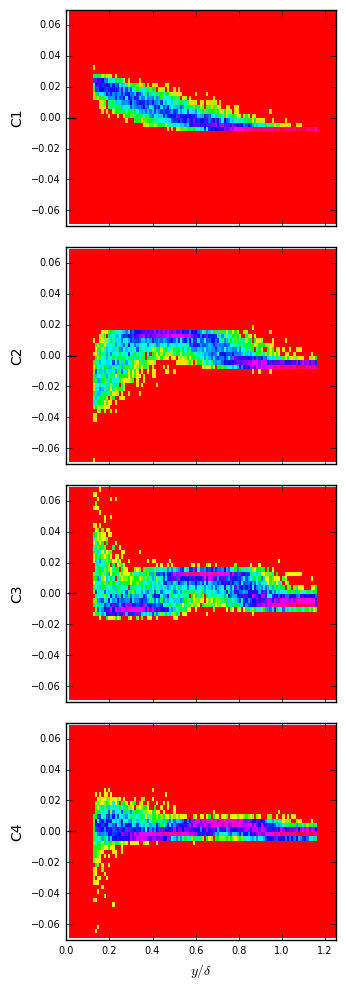

In [105]:
reload(PODutils)
C2 = outLLEmod.copy()
C2 = np.concatenate([ypos.reshape((-1, 1)).T, C2.T], axis=0)
PODutils.plotYposPODcoeff(Y[:,0],C2,list(range(ncomp)),50,0.07,1,saveFolder=(saveFolder + '/Rand_YposCoeff_mod.tif'))